# Retrieval

Retrieval is the centerpiece of our retrieval augmented generation (RAG) flow. 

Let's get our vectorDB from before.

In this lesson, we're going to deep dive on retrieval and cover a few more advanced methods for overcoming those edge cases. 

![Retrieval](immagini/25_retrieval.png)

In this lesson, we're going to talk about retrieval. 

This is important at __QUERY TIME__, when you've got a query that comes in and you want to retrieved the most relevant splits. 

We talked in the previous lesson about semantic similarity search, but we're going to talk about a few different and more advanced methods here. 


![Retrieval](immagini/26_retrieval.png)

The first one we're going to cover is __MAXIMUM MARGINAL RELEVANCE__, or MMR. And so the idea behind this is that if you just always take the documents that are most similar to the query in the embedding space, you may actually miss out on diverse information, as we saw in one of the edge cases. 

In this example, we've got a chef asking about all white mushrooms. And so if we take a look at the most similar results, those would be the first two documents, where they have a lot of information similar to the query about a fruiting body and being all white. 

But we really want to make sure that we also get other information, like the fact that it's really poisonous. And so this is where using MMR comes into play, as it will select for a diverse set of documents. 

![Retrieval](immagini/27_retrieval.png)

The __idea__ behind MMR is that we send a query in, and then we initially get back a set of responses, with "fetch_k" being a parameter that we can control in order to determine how many responses we get. 

This is based solely on semantic similarity. From there, we then work with that smaller set of documents and optimize for not only the most relevant ones, based on semantic similarity, but also ones that are diverse. And from that set of documents, we choose a final "k" to return to the user. 


![Retrieval](immagini/28_retrieval.png)

Another type of retrieval we can do is what we call __SELF-QUERY__. So this is useful when you get questions that aren't solely about the content that you want to look up semantically, but also include some mention of some metadata that you want to do a filter on. 

So let's take the question, what are some movies about aliens made in 1980? 

This really has two components to it. It's got a semantic part, the aliens bit. So we want to look up aliens in our database of movies. 
But it's also got a piece that really refers to the metadata about each movie, which is the fact that the year should be 1980. 

What we can do is we can use a language model itself to split that original question into two separate things, __a FILTER and a SEARCH TERM__. Most vector stores support a metadata filter. 
So you can easily filter records based on metadata, like the year being 1980.  


![Retrieval](immagini/29_retrieval.png)

Finally, we'll talk about __COMPRESSION__. This can be useful to really pull out only the most relevant bits of the retrieved passages. 

For example, when asking a question, you get back the whole document that was stored, even if only the first one or two sentences are the relevant parts. With compression, you can then run all those documents through a language model and extract the most relevant segments and then pass only the most relevant segments into a final language model call. This comes at the cost of making more calls to the language model, but it's also really good for focusing the final answer on only the most important things. And so it's a bit of a tradeoff. 


## Vectorstore retrieval


In [ ]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [ ]:
#!pip install lark

### Similarity Search

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'

In [ ]:
embedding = OpenAIEmbeddings()
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [ ]:
print(vectordb._collection.count())

*OUTPUT*

209

Let's now go over the example of max marginal relevance. 

In [ ]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

We'll create a small database that we can just use as a toy example.

In [ ]:
smalldb = Chroma.from_texts(texts, embedding=embedding)

In [ ]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

We've got our question, and now we can run a similarity search. We'll set "k=2" to only return the two most relevant documents. And we can see that there is no mention of the fact that it is poisonous. 

In [ ]:
smalldb.similarity_search(question, k=2)

*OUTPUT*
![Retrieval](immagini/30_retrieval.png)

Let's now run it with MMR. While it's passing "k=2", we still want to return two documents, but let's set "fetch_k=3", where we fetch all three documents originally. 

In [ ]:
smalldb.max_marginal_relevance_search(question,k=2, fetch_k=3)

*OUTPUT*
![Retrieval](immagini/31_retrieval.png)

We can now see that the information that is poisonous is returned among the documents that we retrieved. 

### Addressing Diversity: Maximum marginal relevance

Last class we introduced one problem: how to enforce diversity in the search results.
 
`Maximum marginal relevance` strives to achieve both relevance to the query *and diversity* among the results.

In [ ]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

To refresh your memory, we can take a look at the first two documents, just looking at the first few characters because they're pretty long otherwise, and we can see that they're the same. 

In [ ]:
docs_ss[0].page_content[:100]

*OUTPUT*
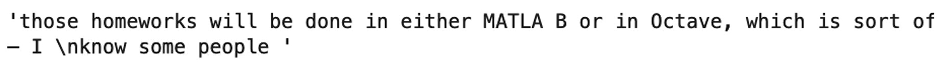

In [ ]:
docs_ss[1].page_content[:100]

*OUTPUT*
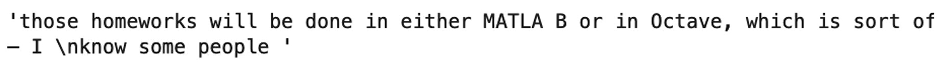

Note the difference in results with `MMR`.

In [ ]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)

In [ ]:
docs_mmr[0].page_content[:100]

*OUTPUT*
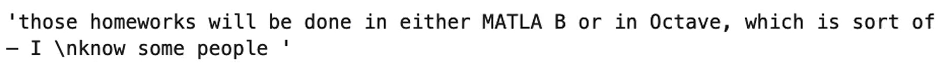

In [ ]:
docs_mmr[1].page_content[:100]

*OUTPUT*
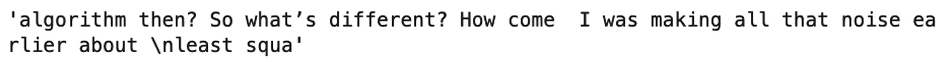

When we run MMR on these results, we can see that the first one is the same as before because that's the most similar. But when we go on to the second one, we can see that it's different. It's getting some diversity in the responses. 

### Addressing Specificity: working with metadata

In last lecture, we showed that a question about the third lecture can include results from other lectures as well.

To address this, many vectorstores support operations on `metadata`.

`metadata` provides context for each embedded chunk.

In [ ]:
question = "what did they say about regression in the third lecture?"

Let's now move on to the self-query example. This is the one where we had the question, what did they say about regression in the third lecture? And it returned results from not just the third lecture, but also the first and the second. If we were fixing this by hand, what we would do is we'd specify a metadata filter. 

So we'd pass in this information that we want the source to be equal to the third lecture PDF. 

In [ ]:
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"docs/cs229_lectures/MachineLearning-Lecture03.pdf"}
)

In [ ]:
for d in docs:
    print(d.metadata)

*OUTPUT*
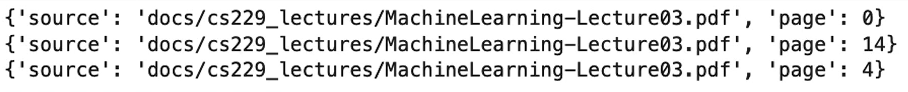

And then if we look at the documents that would be retrieved, they'd all be from exactly that lecture. 

### Addressing Specificity: working with metadata using self-query retriever

But we have an interesting challenge: we often want to infer the metadata from the query itself.

To address this, we can use `SelfQueryRetriever`, which uses an LLM to extract:
 
1. The `query` string to use for vector search
2. A metadata filter to pass in as well

Most vector databases support metadata filters, so this doesn't require any new databases or indexes.

In [ ]:
from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo   # which is where we can specify different fields 
                                                                    # in the metadata and what they correspond to

We only have two fields in the metadata:
- source and 
- page. 

We fill out a description of the name, the description, and the type for each of these attributes. __This information is actually going to be passed to the language model, so it's important to make it as descriptive as possible.__

In [ ]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `docs/cs229_lectures/MachineLearning-Lecture01.pdf`, `docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or `docs/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

We'll then specify some information about what's actually in this document store. We'll initialize the language model, and then we'll initialize the self-query retriever using the "from_llm" method and passing in the language model, the underlying vector database that we're going to query, the information about the description and the metadata, and then we'll also pass in "verbose=True".  

In [ ]:
document_content_description = "Lecture notes"
llm = OpenAI(temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [ ]:
question = "what did they say about regression in the third lecture?"

**You will receive a warning** about predict_and_parse being deprecated the first time you executing the next line. This can be safely ignored.

Setting "verbose=True" will let us see what's going on underneath the hood when the LLM infers the query that should be passed along with any metadata filters. When we run the self-query retriever with this question, we can see, thanks to "verbose=True", that we're printing out what's going on under the hood. 

We get a query of regression, this is the semantic bit, and then we get a filter where we have a comparator of equals between the source attribute and a value of docs and then this path, which is the path to the third machine learning lecture. So this is basically telling us to do a lookup in the semantic space on regression and then do a filter where we only look at documents that have a source value of this value. 

In [ ]:
docs = retriever.get_relevant_documents(question)

*OUTPUT*

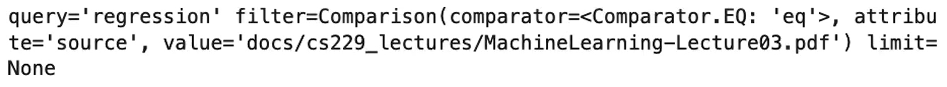

In [ ]:
for d in docs:
    print(d.metadata)

*OUTPUT*

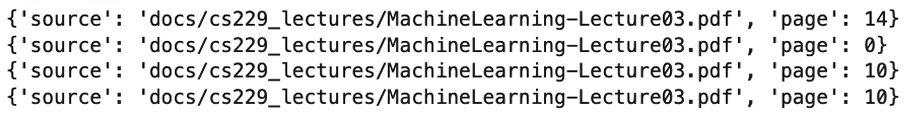

And so if we loop over the documents and print out the metadata, we should see that they're all from this third lecture. And indeed they are. So this is an example where the self-query retriever can be used to filter exactly on metadata. 

### Additional tricks: compression

Another approach for improving the quality of retrieved docs is compression.

Information most relevant to a query may be buried in a document with a lot of irrelevant text. 

Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. 

A final retrieval technique that we can talk about is __CONTEXTUAL COMPRESSION__. And so let's load in some relevant modules here, the contextual compression retriever and then an LLM chain extractor.

And what this is going to do is this is going to extract only the relevant bits from each document and then pass those as the final return response. We'll define a nice little function to pretty print out docs because they're often long and confusing and this will make it easier to see what's going on.  

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

We'll define a nice little function to pretty print out docs because they're often long and confusing and this will make it easier to see what's going on.  

In [ ]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [ ]:
# Wrap our vectorstore
llm = OpenAI(temperature=0)
compressor = LLMChainExtractor.from_llm(llm)

We can then create a compressor with the LLM chain extractor and then we can create the contextual compression retriever passing in the compressor and then the base retriever of the vector store.  

In [ ]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [ ]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

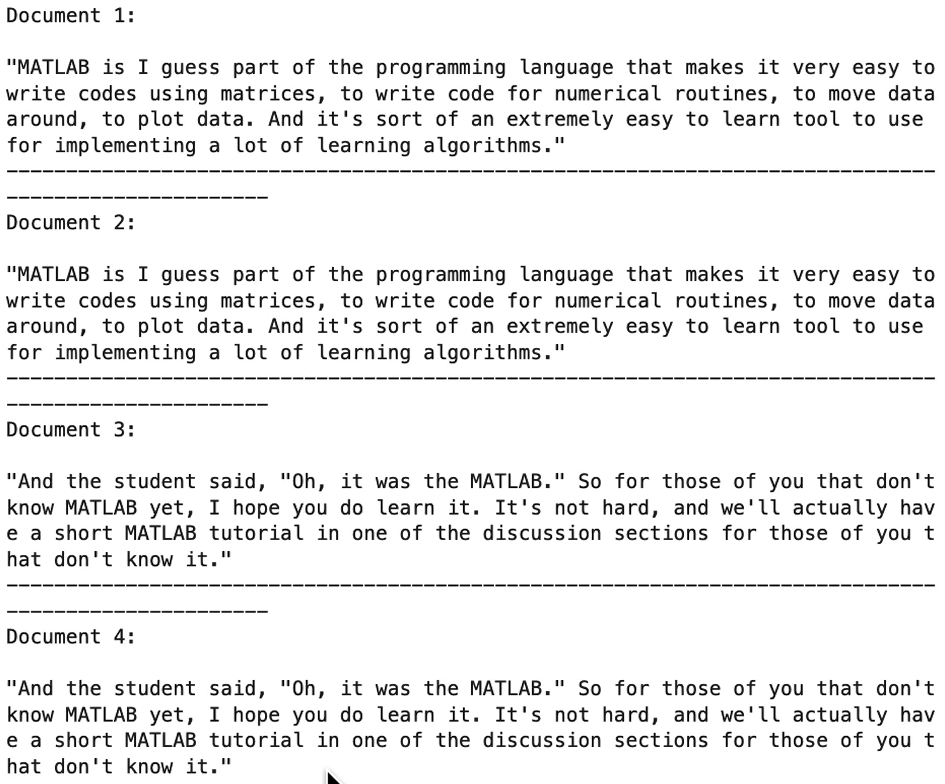

if we look at the documents we get back, we can see two things. One, they are a lot shorter than the normal documents. 

But two, we've still got some of this __repeated stuff__ going on and this is because under the hood we're using the __semantic search algorithm__. This is what we solved by using MMR from earlier in this lesson. This is a good example of where you can combine various techniques to get the best possible results. In order to do that, when we're creating the retriever from the vector database, we can set the search type to MMR. We can then rerun this and see that we get back a filtered set of results that do not contain any duplicate information. 


## Combining various techniques

All the additional retrieval techniques that we've mentioned build on top of a vector database. It's worth mentioning that there's other types of retrieval that don't use a vector database at all and instead uses other more traditional NLP techniques.  

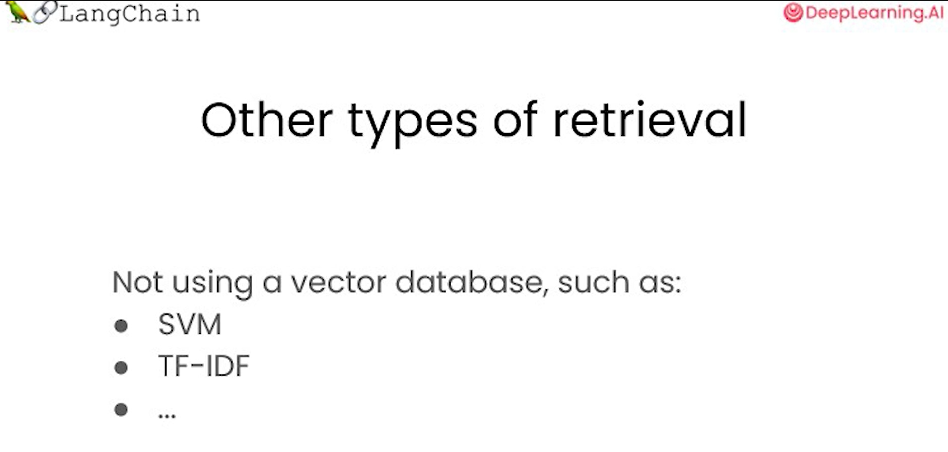

In [ ]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [ ]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

## Other types of retrieval

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

__We're going to recreate a retrieval pipeline with two different types of retrievers, an SVM retriever and a TF-IDF retriever__.

In [ ]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

If you recognize these terms from traditional NLP or traditional machine learning, that's great. If you don't, it's also fine. This is just an example of some other techniques that are out there. There are plenty more besides these and I encourage you to go check out some of them. We can run through the usual pipeline of loading and splitting pretty quickly. 

In [ ]:
# Load PDF
loader = PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)


And then both of these retrievers expose a from text method. One takes in an embedding module, that's the SVM retriever, and the TF-IDF retriever just takes in the splits directly. Now we can use the other retrievers.

In [ ]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [ ]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

*OUTPUT*

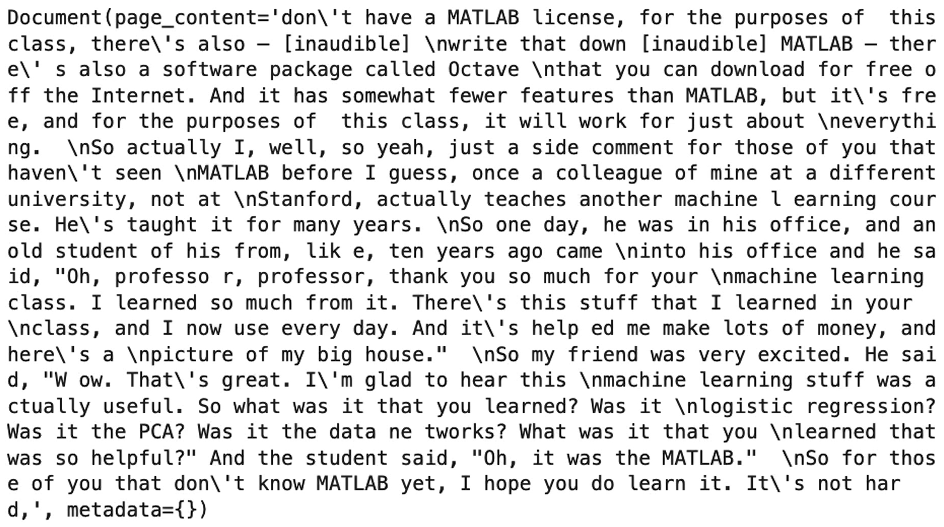

Let's pass in what did they say about MATLAB to the SVM retriever and we can look at the top document we get back and we can see that it mentions a lot of stuff about MATLAB, so it's picking up some good results there. We can also try this out on the TF-IDF retriever and we can see that the results look a little bit worse.

In [ ]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]

*OUTPUT*

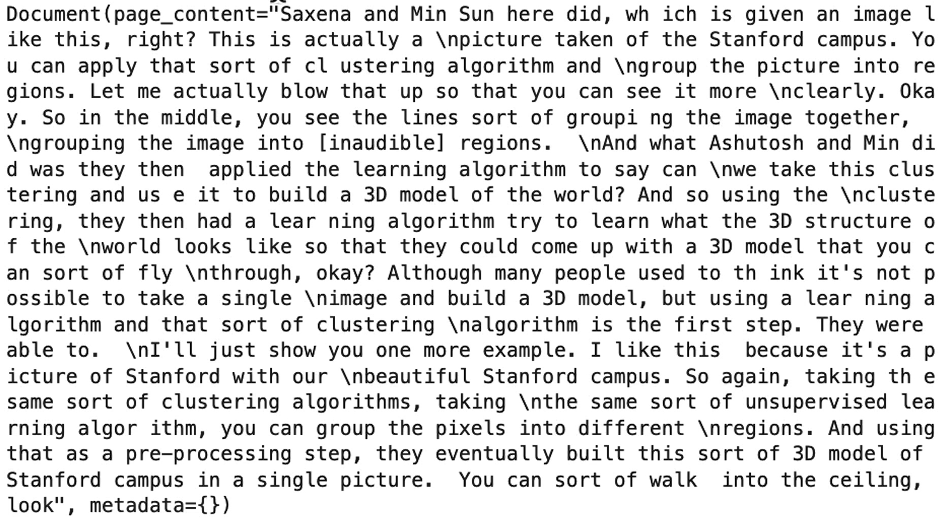